# Описание задачи

**Цель:** требуется предсказать уйдет клент или нет.

Данная задача на бинарную классификацию. Метрику будем использовать ROC-AUC, ее можно вычислить без конкретного порога классификации + она работает для несбалансированных данных

Задача взята с соревновательной платформы kaggle: https://www.kaggle.com/competitions/advanced-dls-spring-2021/overview


Результат - score 85% (0.85312) !

# Начало работы

## Подключение библиотек

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


import time
from math import ceil

from scipy.stats import chi2_contingency, ttest_ind, probplot, mannwhitneyu

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve

from sklearn.pipeline import make_pipeline


%matplotlib inline
sns.set(rc={"figure.figsize": (20, 20)})
sns.set_style("whitegrid")

## Функции и переменные

In [2]:
RANDOM_STATE = 100
SPLIT_TEST_SIZE = 0.2 # размер тестовой выборки
NUM_SPLIT_FOR_GRID = 5 #на сколько частей будет разбиваться выборка при подборе параметров
TRESHOLD_FOR_CORR = 0.1 #порог значения корреляции, ниже которого будем отбрасывать признаки
TRESHOLD_FOR_HIGH_CORR = 0.6 #при этом пороге корреляции будем тщательнее исследовать на предмет выбросов
TRESHOLD_FOR_HIGH_CORR_BETWEEN_FEATURE = 0.8 #если корреляция выше - удаляемм один из коррелируемых признаков 
COLOR_PLOT = 'deepskyblue'

def del_from_list(list_el, new_el):
    """
    Функция удаления элементов из массива
    """
    if np.isin(new_el, list_el).sum():
        return np.setdiff1d(list_el, new_el)
    else:
        return list_el

def add_into_list(list_el, new_el):
    """
    Функция добавления списка элементов в массив
    """
    if np.isin(new_el, list_el).sum() == 0:
        return np.append(list_el, new_el)
    else:
        return list_el
    
def ksi(data, X, Y):
    for i, j in zip(X, Y):

        CrosstabResult = pd.crosstab(index=data[i], columns=data[j])
        
        ChiSqResult = chi2_contingency(CrosstabResult)
        print(f"P-Value χ² теста между группами {i} и {j} = {ChiSqResult[1]}\n")

## Загрузка данных

In [3]:
train = pd.read_csv('data/train.csv')
train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [4]:
test = pd.read_csv('data/test.csv')
test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


## Основная информация о данных

In [5]:
print('Форма тренировочной выборки: ' + str(train.shape))
print('Форма тестовой выборки: ' + str(test.shape))

Форма тренировочной выборки: (5282, 20)
Форма тестовой выборки: (1761, 19)


МЫ видим по 19 признаков в каждой выборке + целевой в тренировочной

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Мы наблюдаем, что у нас нет  значений NaN ни в одном признаке, всего наблюдений 5282. 3 признака (не считая целевой) - числовые, остальные - категориальные


# Анализ целевой переменной

Здесь мы рассмотрим на сколько сбалансированы наши классы целевой переменной

In [7]:
val_churn = train.Churn.value_counts()
val_churn

0    3898
1    1384
Name: Churn, dtype: int64

Ушедших клиентов примерно в 3 раза больше, чем не ушедших, наши классы не сбалансированы, соотетственно мы не можем пользоваться метриками accuracy + обязательно использовать стратифицированную валидацию. Построим график распределения целевого признака для наглядности

Text(0.5, 1.0, 'Распределение целевой переменной')

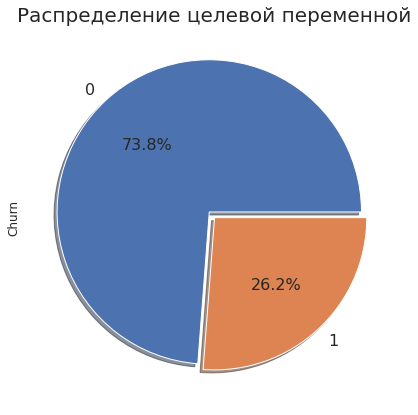

In [8]:
plt.figure(figsize=(7,7))
val_churn.plot.pie(explode=[0.05,0.001], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).\
    set_title('Распределение целевой переменной', fontsize=20)

# Типы данных

In [9]:
train.dtypes.value_counts()

object     16
int64       3
float64     1
dtype: int64

Посмотрим на количество уникальных значений в каждом признаке

In [10]:
dtypes_count = pd.DataFrame({'count': train.nunique(), 'dtype': train.dtypes}, index=train.columns)
dtypes_count

,count,dtype
ClientPeriod,73,int64
MonthlySpending,1468,float64
TotalSpent,4978,object
Sex,2,object
IsSeniorCitizen,2,int64
HasPartner,2,object
HasChild,2,object
HasPhoneService,2,object
HasMultiplePhoneNumbers,3,object
HasInternetService,3,object


По таблице можно заметить, что числовой признак IsSeniorCitizen является на самом деле категориальным. Итого имеем всего только три числовых признака: ClientPeriod, MonthlySpending, TotalSpent(у которого тип object - позже поменяем на float). Определим списка категориальных и числовых признаков, а  так же полный массив всех признаков feature_cols

In [11]:
num_cols = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
cat_cols = [col for col in train.columns if col not in num_cols and col!='Churn']

In [12]:
feature_cols = num_cols + cat_cols
target_col = 'Churn'

## Категориальные признаки

Посмотрим на датасет из одних категориальных признаков

In [13]:
train[cat_cols].head()

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)


Наблюдаем странные значения в некоторых колонках, например в колонке HasOnlineSecurityService значение 'No internet service' при других имеющихся 'No' - может это на самом деле одно и тоже значение? Проверим

In [14]:
for col in cat_cols:
    print(col, ':', train[col].unique())

Sex : ['Male' 'Female']
IsSeniorCitizen : [0 1]
HasPartner : ['Yes' 'No']
HasChild : ['Yes' 'No']
HasPhoneService : ['Yes' 'No']
HasMultiplePhoneNumbers : ['No' 'Yes' 'No phone service']
HasInternetService : ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService : ['No internet service' 'No' 'Yes']
HasOnlineBackup : ['No internet service' 'No' 'Yes']
HasDeviceProtection : ['No internet service' 'No' 'Yes']
HasTechSupportAccess : ['No internet service' 'Yes' 'No']
HasOnlineTV : ['No internet service' 'No' 'Yes']
HasMovieSubscription : ['No internet service' 'No' 'Yes']
HasContractPhone : ['One year' 'Two year' 'Month-to-month']
IsBillingPaperless : ['No' 'Yes']
PaymentMethod : ['Mailed check' 'Credit card (automatic)' 'Electronic check'
 'Bank transfer (automatic)']


Значения 'No internet service' выглядят скорее как имеющийся 'No', логично будет эти значения заменить. Но это мы проделаем (возможно)позже, после тщательного анализа этих признаков и влияния их значений на целевую (если 'No' и 'No internet service' влияют на целевую похоже, то, скорее всего, они означают одно и то же)

## Числовые признаки

pd.info выше нам выдало, что у признака TotalSpent тип object, хотя это числовое значение. Преобразуем к типу float64

In [15]:
train.TotalSpent = pd.to_numeric(train.TotalSpent.str.strip())

In [16]:
train.TotalSpent.head()

0    1026.35
1    1872.20
2      75.90
3    2570.00
4    6758.45
Name: TotalSpent, dtype: float64

# Анализ категориальных переменных

## Распределение признаков

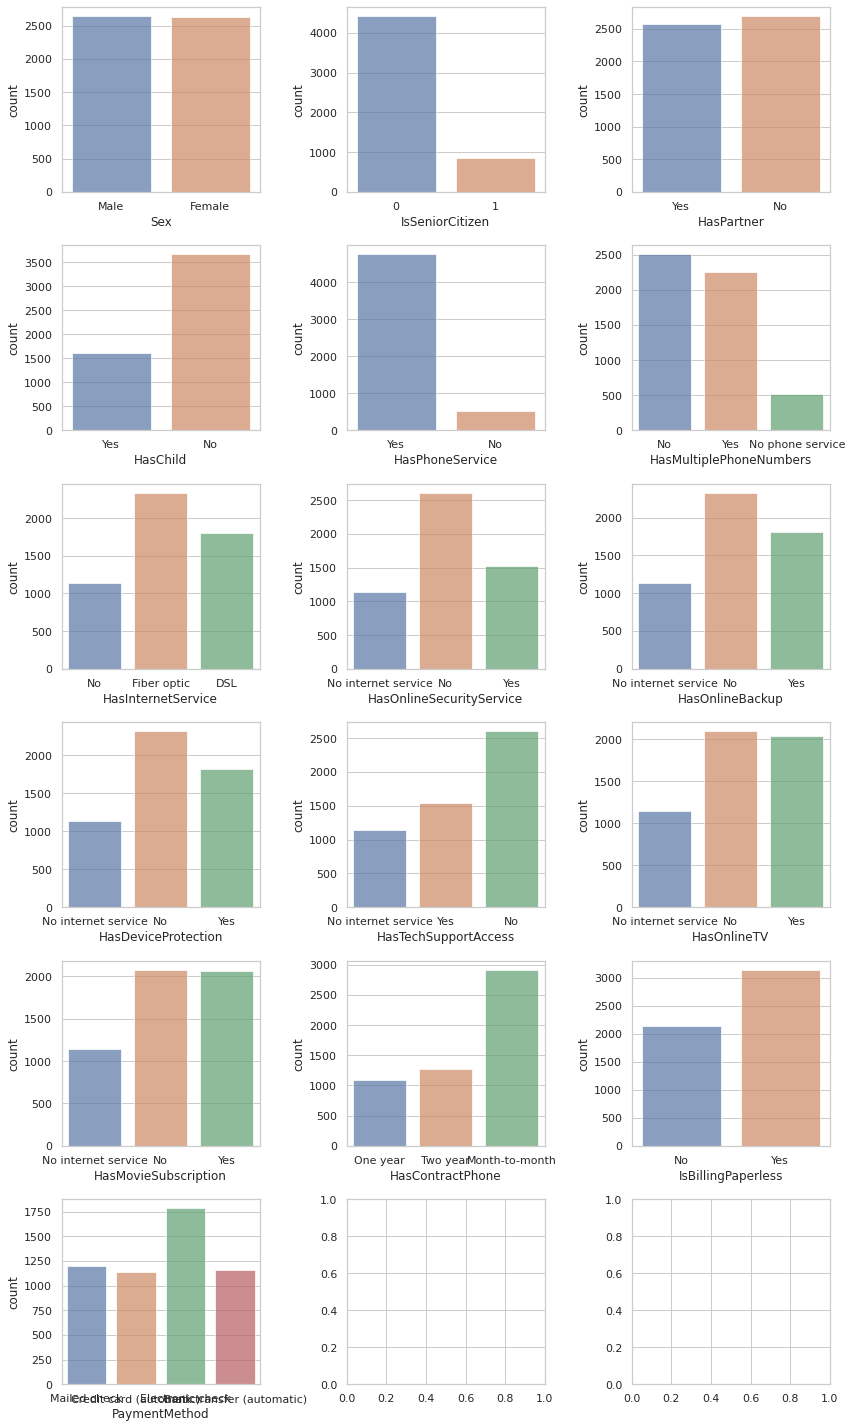

In [17]:
fig, axes = plt.subplots(ceil(len(cat_cols)/3), 3, figsize=(12,20))
for y, col in enumerate(cat_cols):
    i, j  = divmod(y, 3)
    sns.countplot(data=train, x=col, alpha=0.7, ax=axes[i,j])
fig.tight_layout()    

По графикам видим:
+ значений 'No internet service' довольно много
+ значения признаков HasPartner, 'Sex' распределены довольно равномерно 
+ в признаках IsSeniorCitizen, 'HasChild', 'HasPhoneService', 'HasContractPhone' довольно большой перевес в пользу одного значения

## Влияние признаков на целевую переменную

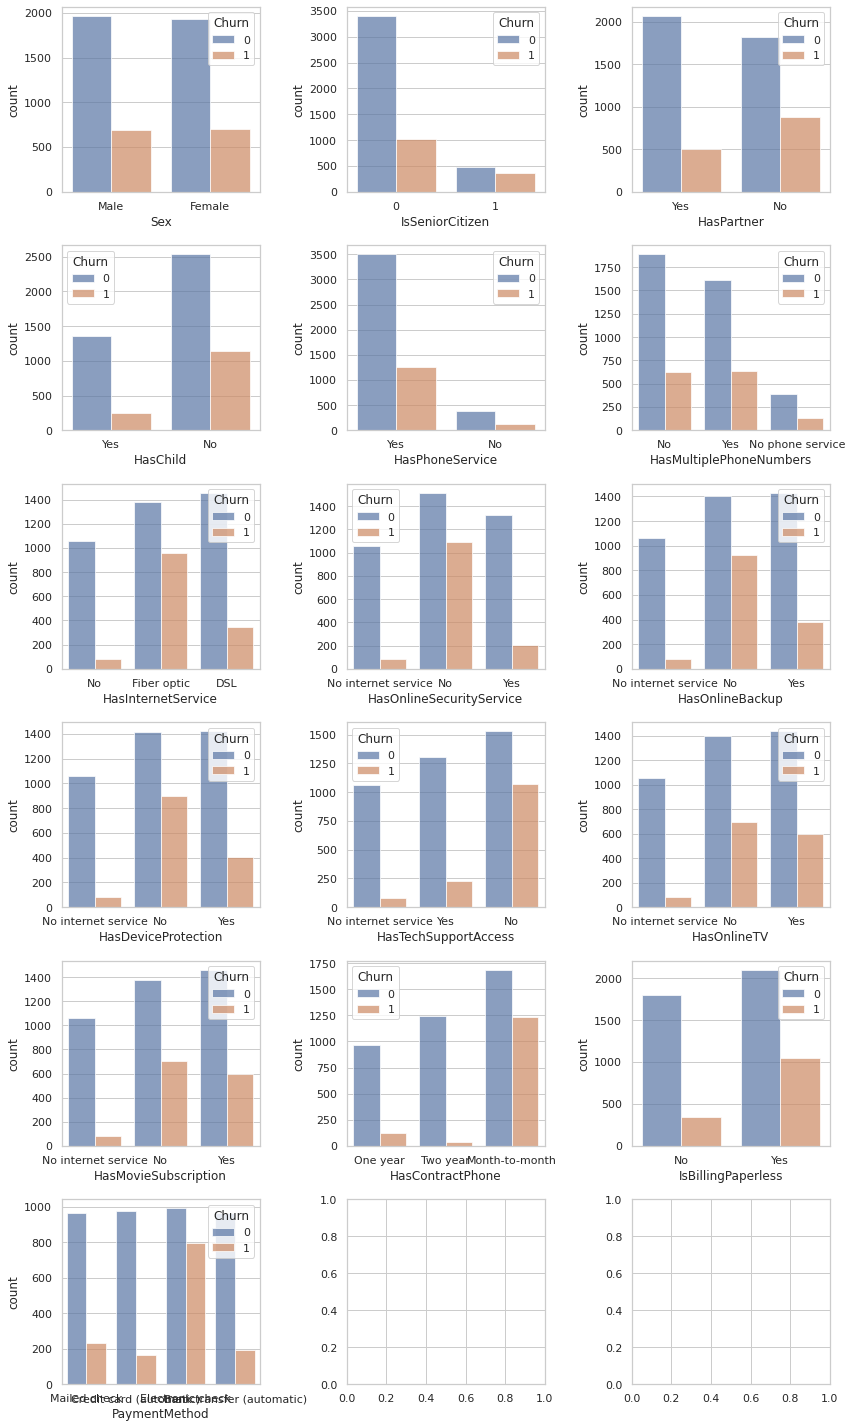

In [18]:
fig, axes = plt.subplots(ceil(len(cat_cols)/3), 3, figsize=(12,20))
for y, col in enumerate(cat_cols):
    i, j = divmod(y, 3)
    sns.countplot(data=train, x=col, hue='Churn', alpha=0.7, ax=axes[i,j])
fig.tight_layout() 

Самый важный вывод из данных графиков - это что значение 'No internet service' НЕ является аналогом значений 'No' в признаках, которые содержат эти значения, тк влияние этих признаков на целевую очень сильно отличается. Кроме того можно сделать следующие интересные выводы:
+ Признаки Sex, HasPhoneService не заметно что влияют на целевую - для них проведем χ² тест - возможно, их стоит исключить из дальнейшего анализа

+ Больше шансов, что пользователь уйдет, когда: IsSeniorSitizen = 1, HasParnter='No', HasChild='No', HasInternetService='FiberOptic', HasOnlineSecurityService='No', HasOnlineBackup='No', 'HasDeviceProtection' = 'No', HasTYechSupportAccess='No', HasContractPhone='Month-to-month', IsBillingPaperless='Yes', PaymentMethod='Electronic check'

В целом признаки демонстрируют очень хорошее влияние на целевую переменную

## Проверка зависимости целевой переменной

Проведем χ² тест для того, чтоб понять на сколько равномерно распределение целевого признака по значениям Sex, HasPhoneService


In [19]:
cols = ['Sex', 'HasPhoneService']
for col in cols:
    CrosstabResult = pd.crosstab(index=train[col], columns=train.Churn)
    ChiSqResult = chi2_contingency(CrosstabResult)
    print(f"P-Value χ² теста между группами {col} и Churn = {ChiSqResult[1]}\n")

P-Value χ² теста между группами Sex и Churn = 0.5661255394927714

P-Value χ² теста между группами HasPhoneService и Churn = 0.46173681534370814



значение p-value << 0.05, поэтому делаем вывод, что наши переменные Sex, HasPhoneService действтельно никак не влияют на целевую, соответственно их можно исключить из дальнейшего анализа

In [20]:
col_for_del = ['Sex', 'HasPhoneService']
cat_cols = del_from_list(cat_cols, col_for_del)
train = train.drop(col_for_del, axis=1)
test = test.drop(col_for_del, axis=1)

Выведем получившуюся выборку из одних категориальных признаков

In [21]:
train[cat_cols].head()

,HasChild,HasContractPhone,HasDeviceProtection,HasInternetService,HasMovieSubscription,HasMultiplePhoneNumbers,HasOnlineBackup,HasOnlineSecurityService,HasOnlineTV,HasPartner,HasTechSupportAccess,IsBillingPaperless,IsSeniorCitizen,PaymentMethod
0,Yes,One year,No internet service,No,No internet service,No,No internet service,No internet service,No internet service,Yes,No internet service,No,0,Mailed check
1,No,Two year,No internet service,No,No internet service,Yes,No internet service,No internet service,No internet service,Yes,No internet service,No,0,Credit card (automatic)
2,No,Month-to-month,No,Fiber optic,No,No,No,No,No,No,Yes,Yes,0,Electronic check
3,No,Month-to-month,Yes,Fiber optic,No,Yes,No,No,No,Yes,No,No,1,Mailed check
4,Yes,Two year,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,0,Credit card (automatic)


По первым 5 строчкам видим схожесть в значениях признаков HasOnlineTV, HasMovieSubscription, HasOnlineBackup, HasOnlineSecurityService(размещены в порядке увеличения значимости влияния на целевую по графикам из п.5.2). Каждый признак сравним с другим (проверка на мулльтиколлинеарность модели)

## Взаимосвязь между признаками

Анадиз будем проводить для признаков в порядке возрастания их влияния на целевую, т.е. вначале самая слабо влияющая HasOnlineTV

**HasOnlineTV**

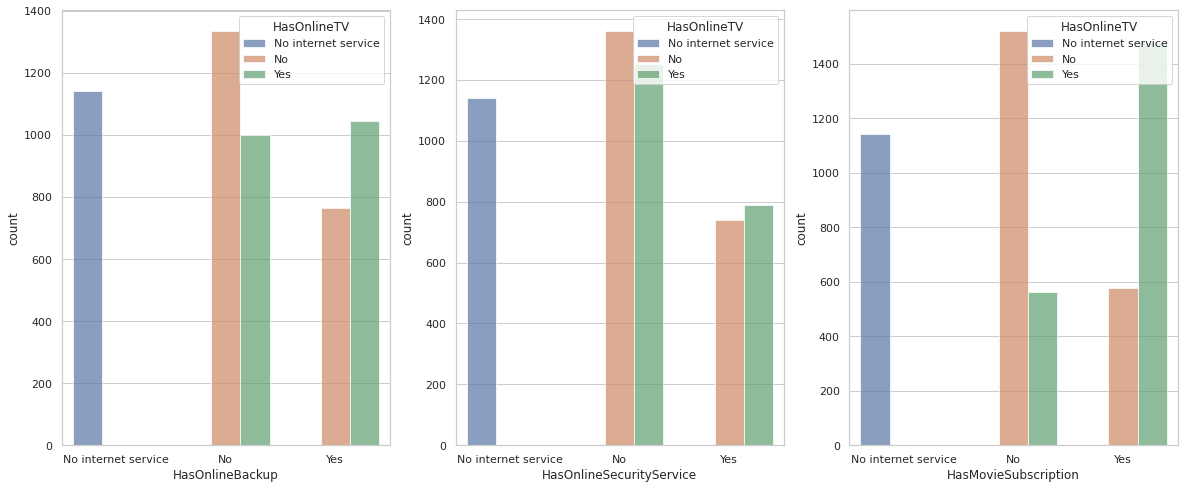

In [22]:
cols = ['HasOnlineBackup', 'HasOnlineSecurityService', 'HasMovieSubscription']
fig, axes = plt.subplots(ncols=3, figsize=(20,8))
for y, col in enumerate(cols):
    sns.countplot(data=train, x=col, hue='HasOnlineTV', alpha=0.7, ax=axes[y])

Проведем χ² тест, чтоб обнаружить связаны ли признаки 'HasOnlineBackup', 'HasOnlineSecurityService', 'HasMovieSubscription' с 'HasOnlineTV'. При этом заметим, что значение 'No internet service', которое копируется в данных признаках, может перетянуть все на себя, поэтому для честности, стоит провести тест только для наблюдений, значение которых отлично от него. Конечно, в будущем нужно будет обязательно разобраться с этими повторами, возможно, путем разделения выборки на 2 части и отдельного моделирования для каждой из них.

In [23]:
train_with_internet = train[train['HasMovieSubscription'] != 'No internet service']
train_with_internet.head()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,HasPartner,HasChild,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2,1,75.90,75.90,0,No,No,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,1,Yes,No,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,0,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
6,27,90.15,2423.40,0,Yes,No,Yes,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,No,Bank transfer (automatic),0
7,1,45.70,45.70,0,No,No,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1


In [24]:
ksi(train_with_internet, ['HasOnlineTV', 'HasOnlineTV', 'HasOnlineTV'], \
    ['HasOnlineBackup','HasOnlineSecurityService', 'HasMovieSubscription'])

P-Value χ² теста между группами HasOnlineTV и HasOnlineBackup = 2.289132206313967e-21

P-Value χ² теста между группами HasOnlineTV и HasOnlineSecurityService = 0.02214081044582294

P-Value χ² теста между группами HasOnlineTV и HasMovieSubscription = 1.7272315502196066e-183



Значение p-value << 0.5, значения распределены не равномерно между этими признаками => есть взаимосвязь => для предупреждения мультиколлинеарности модели исключаем признак HasOnlineTV, тем более что график из п.5.2 демонстрирует , что данный признак слабо влияет на целевую (значение 'No internet service' здесь и далее будем опускать, тк оно копируется в других признаках). 

In [25]:
col_for_del = ['HasOnlineTV']
cat_cols = del_from_list(cat_cols, col_for_del)
train = train.drop(col_for_del, axis=1)
test = test.drop(col_for_del, axis=1)

**HasMovieSubscription**

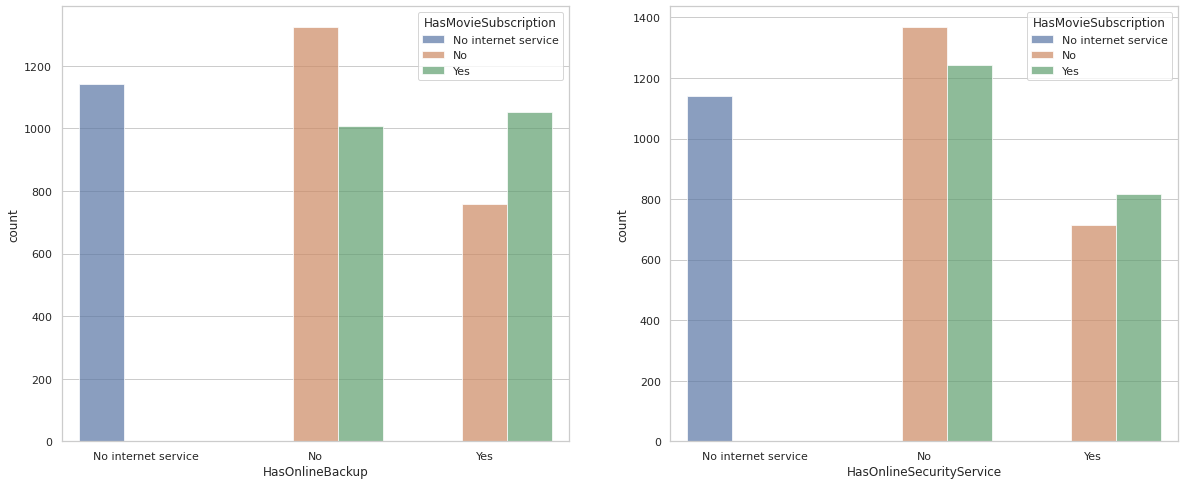

In [26]:
cols = ['HasOnlineBackup', 'HasOnlineSecurityService']
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
for y, col in enumerate(cols):
    sns.countplot(data=train, x=col, hue='HasMovieSubscription', alpha=0.7, ax=axes[y])

По данным графикам не наблюдается сильной взаимосвязи значений с признаком HasMovieSubscription, проведем χ² тест для выявления влияния этого признака на целевую:

In [27]:
ksi(train_with_internet, ['HasMovieSubscription'],  ['Churn'])

P-Value χ² теста между группами HasMovieSubscription и Churn = 0.0007782786957002362



Тест показал, что распределение все ж не равномерно (P-Value < 0.05), поэтому оставим данный признак в анализе

**HasOnlineBackup**

<AxesSubplot:xlabel='HasOnlineSecurityService', ylabel='count'>

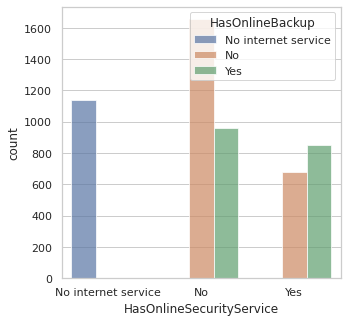

In [28]:
plt.figure(figsize=(5,5))
sns.countplot(data=train, x='HasOnlineSecurityService', hue='HasOnlineBackup', alpha=0.7)

Критичной взаимосвязи не наблюдаем + есть влияние на целевую, оставляем в анализе оба признака.

**А теперь убедимся, что если в одном признаке из HasOnlineSecurityService, HasOnlineBackup, HasDeviceProtection, HasTechSupportAccess, HasMovieSubscription значение 'No internet service', значит в остальных всех так же должно быть (иначе - ошибочное значение)**

In [29]:
cols_internet = ['HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', \
                 'HasMovieSubscription']
for col in cols_internet:
    print('Наблюдений с искомым значением в колонке', col,':',(train[col]=='No internet service').sum(), end='\n\n')


Наблюдений с искомым значением в колонке HasOnlineSecurityService : 1141

Наблюдений с искомым значением в колонке HasOnlineBackup : 1141

Наблюдений с искомым значением в колонке HasDeviceProtection : 1141

Наблюдений с искомым значением в колонке HasTechSupportAccess : 1141

Наблюдений с искомым значением в колонке HasMovieSubscription : 1141



 мы наблюдаем,что количесвто искомых значений во всех признаках одинаково, но нужно убедиться, что они принадлежат одним и тем же строкам

In [30]:
for col in cols_internet:
    print('Наблюдений с искомым значением в колонке', col,':',(train_with_internet[col]=='No internet service').sum(), end='\n\n')


Наблюдений с искомым значением в колонке HasOnlineSecurityService : 0

Наблюдений с искомым значением в колонке HasOnlineBackup : 0

Наблюдений с искомым значением в колонке HasDeviceProtection : 0

Наблюдений с искомым значением в колонке HasTechSupportAccess : 0

Наблюдений с искомым значением в колонке HasMovieSubscription : 0



Да, у нас все заполнено правильно, ошибок нет.

# Анализ числовых переменных

## Распределение признаков

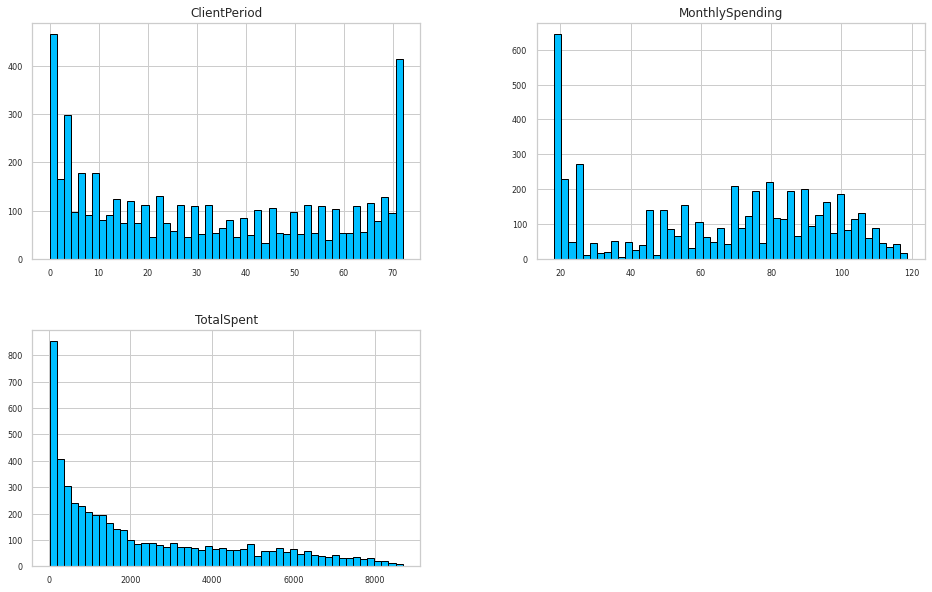

In [31]:
ig_ = train[num_cols].hist(figsize=(16, 10), bins=50, color=COLOR_PLOT,
                         edgecolor="black", xlabelsize=8, ylabelsize=8)

Распределения не нормальные, у признака TotalSpent распределение похоже на логонормальное, у ClientPeriod большая часть наблюдений либо низкие, либо высокие значения принимают 

In [32]:
train[num_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,5282.000000,5282.000000,5273.000000
mean,32.397009,64.924754,2291.390461
std,24.550326,30.176464,2269.014233
min,0.000000,18.250000,18.800000
25%,9.000000,35.462500,401.100000
50%,29.000000,70.400000,1410.250000
75%,55.000000,90.050000,3807.350000
max,72.000000,118.750000,8684.800000


Видим, что медиана ClientPeriod = 29, медиана MonthlySpending = 70.4, минимальное значение при этом 18.25, а у признака TotalSpent медиана = 1410.25, а вот величина среднего аж в 1.5 раз больше, что обуславливается тем, что имеются наблюдения с очень большим значением, разница между 3-ьим квантилем и максимум очень большая - нужно проверить эту переменную на выбросы

## Работа с выбросами

<AxesSubplot:xlabel='TotalSpent'>

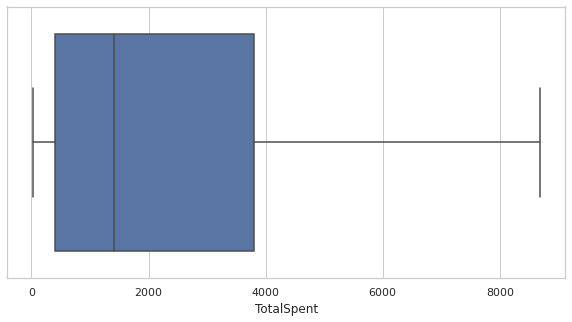

In [33]:
plt.figure(figsize=(10,5))
sns.boxplot(data=train, x='TotalSpent')

Выбросы не замечены.

##  Влияние признаков на целевую переменную + NaN

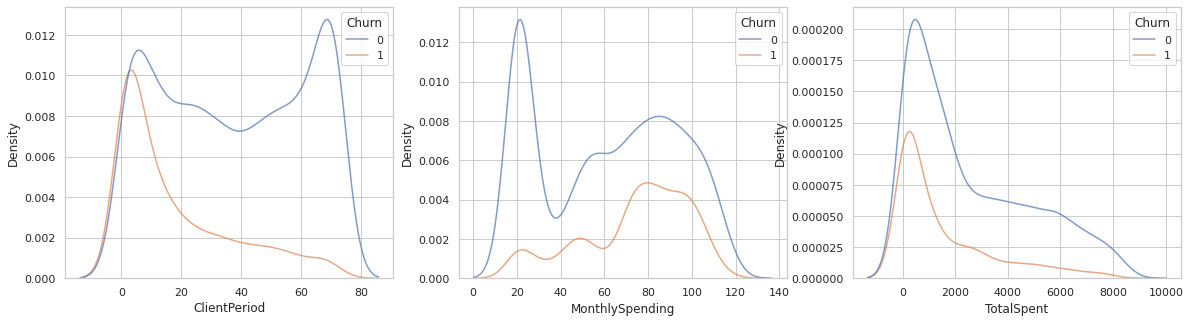

In [34]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
for y, col in enumerate(num_cols):
    sns.kdeplot(data=train, x=col, hue='Churn', alpha=0.7, ax=axes[y])


Большая вероятность ухода клиента при значениях:  
+ ClientPeriod < 2
+ MonthlySpending : от 60 до 100

Самые лояльные клиенты при значениях:
+ ClientPeriod > 60
+ MonthlySpending от 0 до 30

А вот для признака TotalSpent проведем тест на равенство средних, тк визуально не сильно заметно влияние этого признака на целевую

In [35]:
train[train.Churn == 1].TotalSpent.mean()

1525.8318641618523

In [36]:
train[train.Churn == 0].TotalSpent.mean()

2563.8340447415794

Вроде разница средних значений весьма внушительная. Но, чтобы подтвердить цифрами это различие, проведем непараметрический тест Манна-Уитни, тк распределение признака (см. п. 6.1) не нормальное. Только для этого нужно прежде разобраться с отстствующими значениями, которые после преобразования признака TotalSpent в тип float у нас появились (в начале анализа info нам выдавал, что nan не существует, тк в TotalSpent присутствовали пустые строки)

In [37]:
train.TotalSpent.isna().sum()

9

Мы имеем 9 отсутствующих значений, проведем замену их на медианное значение

In [38]:
train.TotalSpent.fillna(train.TotalSpent.median(), inplace=True)

In [39]:
stat, p = mannwhitneyu(train[train.Churn == 1].TotalSpent, train[train.Churn == 0].TotalSpent)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1872844.500, p=0.000


p << 0.05, поэтому мы подтверждаем, что средние в переменной TotalSpent различаются у ушедших клиентов и не ушедших, соответсвенно, оставляем эту переменную для дальнейшего анализа

## Корреляционный анализ

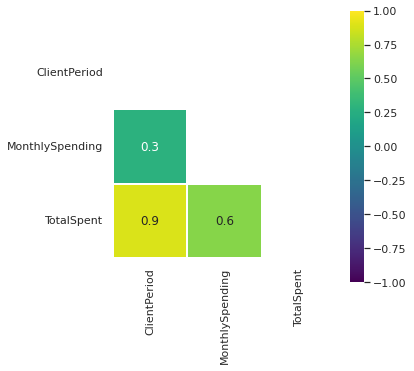

In [40]:
plt.figure(figsize=(5,5))
train_num_corr = train[num_cols]
#признаки распределены не нормально, поэтому используем непараметрическую корреляцию Спирмана
corr_matrix =  train_num_corr.corr(method='spearman')
#для лучшей визуализации обнуляем корреляции, которые ниже заданного порога
corr_matrix[abs(corr_matrix) <= TRESHOLD_FOR_CORR] = 0
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = "viridis"
sns.heatmap(corr_matrix,  mask=mask, linewidths=0.1, vmax=1.0, vmin=-1.0,  square=True, cmap=cmap, 
            annot=True, fmt=".1f");

Вот это да! Корреляция между признаками ClientPeriod и TotalSpent 0.9!! Это очень большое значение, т.к. у TotalSpent так же корреляция выше, чем у ClientPeriod , с признаком MonthlySpending, плюс именно у этого признака мы восстанавливали пропущенные значения, из анализа удалим именно признак TotalSpent.

In [41]:
col_for_del = ['TotalSpent']
num_cols = del_from_list(num_cols, col_for_del)
train = train.drop(col_for_del, axis=1)
test = test.drop(col_for_del, axis=1)

# Feature engineering

Исходя из графиков п.6.3 мы можем ввести дополнительные признаки категориальные, в зависимости от поведения признаков ClientPeriod и MonthlySpending

**ClientPeriod**

In [42]:
train['ClientPeriodInterval'] = np.nan
train.loc[train.ClientPeriod<=2, 'ClientPeriodInterval'] = '0-2'
train.loc[(train.ClientPeriod<=20) & (train.ClientPeriod>2), 'ClientPeriodInterval'] = '2-20'
train.loc[(train.ClientPeriod<=40) & (train.ClientPeriod>20), 'ClientPeriodInterval'] = '20-40'
train.loc[(train.ClientPeriod<=60) & (train.ClientPeriod>40), 'ClientPeriodInterval'] = '40-60'
train.ClientPeriodInterval.fillna('60+', inplace=True)

test['ClientPeriodInterval'] = np.nan
test.loc[test.ClientPeriod<=2, 'ClientPeriodInterval'] = '0-2'
test.loc[(test.ClientPeriod<=20) & (test.ClientPeriod>2), 'ClientPeriodInterval'] = '2-20'
test.loc[(test.ClientPeriod<=40) & (test.ClientPeriod>20), 'ClientPeriodInterval'] = '20-40'
test.loc[(test.ClientPeriod<=60) & (test.ClientPeriod>40), 'ClientPeriodInterval'] = '40-60'
test.ClientPeriodInterval.fillna('60+', inplace=True)

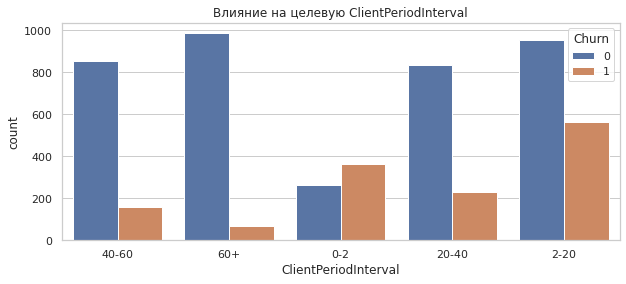

In [43]:
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='ClientPeriodInterval', hue='Churn')

plt.title('Влияние на целевую ClientPeriodInterval');

Самые большие шансы, что пользователь уйдет - ClientPeriodInterval = '0-2', меньше шансов у кого '60+'

**MonthlySpending**

In [44]:
train['MonthlySpendingInterval'] = np.nan
train.loc[train.MonthlySpending<=30, 'MonthlySpendingInterval'] = '0-30'
train.loc[(train.MonthlySpending<=60) & (train.MonthlySpending>30), 'MonthlySpendingInterval'] = '30-60'
train.loc[(train.MonthlySpending<=100) & (train.MonthlySpending>60), 'MonthlySpendingInterval'] = '60-100'
train.MonthlySpendingInterval.fillna('100+', inplace=True)

test['MonthlySpendingInterval'] = np.nan
test.loc[test.MonthlySpending<=30, 'MonthlySpendingInterval'] = '0-30'
test.loc[(test.MonthlySpending<=60) & (test.MonthlySpending>30), 'MonthlySpendingInterval'] = '30-60'
test.loc[(test.MonthlySpending<=100) & (test.MonthlySpending>60), 'MonthlySpendingInterval'] = '60-100'
test.MonthlySpendingInterval.fillna('100+', inplace=True)

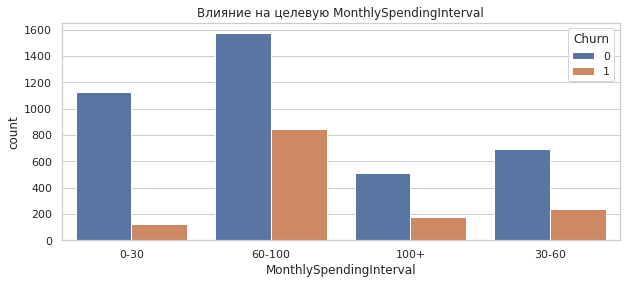

In [45]:
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='MonthlySpendingInterval', hue='Churn')

plt.title('Влияние на целевую MonthlySpendingInterval');

Меньше всего потерять клиента шансов когда MonthlySpendingInterval = '0-30'

**HasNotInternet**

Введем новый признак HasNotInternet и попробуем с ним настроить наши модели, понаблюдаем нужно ли будет или нет рассматривать отдельно тех, у кого интернет есть и у кого его нет. Если нам все равно придется разбивать наши выборки, нам все равно пригодится этот признак.

Мы можем его определить по любому имеющемуся признаку с таким значением, тк, как мы убедились выше, значение 'No internet service' копируется 

In [46]:
train['HasNotInternet'] = (train['HasMovieSubscription'] == 'No internet service').astype(int)
train.head()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,ClientPeriodInterval,MonthlySpendingInterval,HasNotInternet
0,55,19.50,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0,40-60,0-30,1
1,72,25.85,0,Yes,No,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0,60+,0-30,1
2,1,75.90,0,No,No,No,Fiber optic,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,1,0-2,60-100,0
3,32,79.30,1,Yes,No,Yes,Fiber optic,No,No,Yes,No,No,Month-to-month,No,Mailed check,0,20-40,60-100,0
4,60,115.25,0,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0,40-60,100+,0


In [47]:
test['HasNotInternet'] = (test['HasMovieSubscription'] == 'No internet service').astype(int)

In [48]:
cat_cols = add_into_list(cat_cols, ['ClientPeriodInterval', 'MonthlySpendingInterval', 'HasNotInternet'])

**HasInternetService**

Проверим, а не является ли значение 'No' признака HasInternetService аналогом 'No internet service'

In [49]:
(train.HasInternetService == 'No').sum()  - (train.HasOnlineBackup == 'No internet service').sum()

0

In [50]:
((train.HasInternetService == 'No') & (train.HasOnlineBackup != 'No internet service')).sum()

0

Значение No признака HasInternetService полностью повторяет значения 'No internet service'. Несмотря на это, мы ничего делать не будем, тк после получения дамми переменных колонки, соответствующие знчению No для HasInternetService окажутся аналогичные другим, мы просто произвдем удаление дубликатов.

# Подготовка данных к моделированию

## Разделение тренировочной выборки на признаки и целевую переменную

In [51]:
X = train.drop(columns=['Churn'], axis=1).copy()
y = train.Churn.copy()
#сохраним копию, тк для catboost нам не нужно будет заниматься модифицированием категориальных данных и нормировкой чисовых
X_catboost = X.copy()

X_test = test.copy()
X_test_catboost = X_test.copy()

test.head()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,ClientPeriodInterval,MonthlySpendingInterval,HasNotInternet
0,42,56.10,0,Yes,No,Yes,DSL,Yes,No,No,No,No,One year,No,Credit card (automatic),40-60,30-60,0
1,29,98.50,1,Yes,No,Yes,Fiber optic,No,No,Yes,No,Yes,Month-to-month,Yes,Electronic check,20-40,60-100,0
2,9,76.25,0,No,No,Yes,Fiber optic,No,No,No,No,No,Month-to-month,Yes,Electronic check,2-20,60-100,0
3,67,74.00,0,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,Two year,No,Credit card (automatic),60+,60-100,0
4,71,20.10,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),60+,0-30,1


## Удаление признаков

Здесь мы будем удалять некоторые признаки, которые могут мешать обучению модели всвязи с высокой корреляцией с другими признаками, и смотреть, как реагирует модель

In [52]:
#HasInternetService HasPartner  HasTechSupportAccess
#col_for_del = ['HasPartner']
#col_for_del = ['HasInternetService']
#X = X.drop(col_for_del, axis=1)
#X_test = X_test.drop(col_for_del, axis=1)

In [53]:
#num_cols = del_from_list(num_cols, ['ClientPeriod', 'MonthlySpending'])


In [54]:
#cat_cols = add_into_list(cat_cols, ['HasPartner'])
#cat_cols

In [55]:
print('количество пропущенных значений в тренировочной:', X.isna().sum().sum())
print('количество пропущенных значений в тестовой:', X_test.isna().sum().sum())

количество пропущенных значений в тренировочной: 0
количество пропущенных значений в тестовой: 0


## Нормализация числовых признаков

In [56]:
X[num_cols].head()

,ClientPeriod,MonthlySpending
0,55,19.50
1,72,25.85
2,1,75.90
3,32,79.30
4,60,115.25


In [57]:
sc = StandardScaler()

X[num_cols] = sc.fit_transform(X[num_cols])
X_test[num_cols] = sc.transform(X_test[num_cols])
X[num_cols].head()

,ClientPeriod,MonthlySpending
0,0.920767,-1.505447
1,1.613288,-1.294998
2,-1.279005,0.363737
3,-0.016173,0.476418
4,1.124450,1.667856


## Кодирование Категориальных признаков

Признаки, у которых только 2 значения, оставим без изменений, только так, чтоб значения были 0 или 1:

In [58]:
binary_cols = X[cat_cols].nunique()[(X[cat_cols].nunique() == 2)].index.to_list()
binary_cols

['HasChild',
 'HasPartner',
 'IsBillingPaperless',
 'IsSeniorCitizen',
 'HasNotInternet']

In [59]:
X.head()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,ClientPeriodInterval,MonthlySpendingInterval,HasNotInternet
0,0.920767,-1.505447,0,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,40-60,0-30,1
1,1.613288,-1.294998,0,Yes,No,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),60+,0-30,1
2,-1.279005,0.363737,0,No,No,No,Fiber optic,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,0-2,60-100,0
3,-0.016173,0.476418,1,Yes,No,Yes,Fiber optic,No,No,Yes,No,No,Month-to-month,No,Mailed check,20-40,60-100,0
4,1.124450,1.667856,0,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),40-60,100+,0


In [60]:
for col in binary_cols:
    X[col] = (X[col] == 'Yes').astype(int)
    X_test[col] = (X_test[col] == 'Yes').astype(int)

In [61]:
X.head()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,ClientPeriodInterval,MonthlySpendingInterval,HasNotInternet
0,0.920767,-1.505447,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0,Mailed check,40-60,0-30,0
1,1.613288,-1.294998,0,1,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Credit card (automatic),60+,0-30,0
2,-1.279005,0.363737,0,0,0,No,Fiber optic,No,No,No,Yes,No,Month-to-month,1,Electronic check,0-2,60-100,0
3,-0.016173,0.476418,0,1,0,Yes,Fiber optic,No,No,Yes,No,No,Month-to-month,0,Mailed check,20-40,60-100,0
4,1.124450,1.667856,0,1,1,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Two year,0,Credit card (automatic),40-60,100+,0


К остальным категориальным признакам применим One Hot Encoder

In [62]:
last_cat_col = [col for col in cat_cols if col not in binary_cols]
last_cat_col

['HasContractPhone',
 'HasDeviceProtection',
 'HasInternetService',
 'HasMovieSubscription',
 'HasMultiplePhoneNumbers',
 'HasOnlineBackup',
 'HasOnlineSecurityService',
 'HasTechSupportAccess',
 'PaymentMethod',
 'ClientPeriodInterval',
 'MonthlySpendingInterval']

In [63]:
# запомним количество элементов тренировочной выборки
ceil_train = X.shape[0]
ceil_train

5282

In [64]:
all_ds = X.append(X_test, ignore_index=True)
all_ds.head()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,ClientPeriodInterval,MonthlySpendingInterval,HasNotInternet
0,0.920767,-1.505447,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0,Mailed check,40-60,0-30,0
1,1.613288,-1.294998,0,1,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Credit card (automatic),60+,0-30,0
2,-1.279005,0.363737,0,0,0,No,Fiber optic,No,No,No,Yes,No,Month-to-month,1,Electronic check,0-2,60-100,0
3,-0.016173,0.476418,0,1,0,Yes,Fiber optic,No,No,Yes,No,No,Month-to-month,0,Mailed check,20-40,60-100,0
4,1.124450,1.667856,0,1,1,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Two year,0,Credit card (automatic),40-60,100+,0


In [65]:
all_ds = pd.get_dummies(all_ds, columns=[col for col in last_cat_col])
all_ds.head()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,IsBillingPaperless,HasNotInternet,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,...,PaymentMethod_Mailed check,ClientPeriodInterval_0-2,ClientPeriodInterval_2-20,ClientPeriodInterval_20-40,ClientPeriodInterval_40-60,ClientPeriodInterval_60+,MonthlySpendingInterval_0-30,MonthlySpendingInterval_100+,MonthlySpendingInterval_30-60,MonthlySpendingInterval_60-100
0,0.920767,-1.505447,0,1,1,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
1,1.613288,-1.294998,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,-1.279005,0.363737,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,-0.016173,0.476418,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
4,1.124450,1.667856,0,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


Т.к. у нас были идеально повторяющиеся значения  'No internet service' во многих признаках, при кодировании должны были появиться идеально коррелирующие столбцы. Удалим их!

In [66]:
all_ds = all_ds.T.drop_duplicates().T
all_ds.head()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,IsBillingPaperless,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,HasDeviceProtection_No,...,PaymentMethod_Mailed check,ClientPeriodInterval_0-2,ClientPeriodInterval_2-20,ClientPeriodInterval_20-40,ClientPeriodInterval_40-60,ClientPeriodInterval_60+,MonthlySpendingInterval_0-30,MonthlySpendingInterval_100+,MonthlySpendingInterval_30-60,MonthlySpendingInterval_60-100
0,0.920767,-1.505447,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.613288,-1.294998,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-1.279005,0.363737,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.016173,0.476418,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.124450,1.667856,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Таким образом, мы избавились от одинаковых значений, остался только один признак, отвечающий за то, есть интерент или нет, это 'HasDeviceProtection_No internet service', давайте его переименуем!

In [67]:
all_ds.rename(columns = {'HasDeviceProtection_No internet service' : 'NoInternet'}, inplace=True)


Вернемся обратно к тренировочной и тестовой выборкам

In [68]:
X = all_ds[:ceil_train]
X_test = all_ds[ceil_train:]

Перед построением моделей проверим, что тестовая и тренировочная выборки состоят из одинаковых признаков:

In [69]:
col_in_train_notin_test = [col for col in X.columns if col not in X_test.columns]
col_in_test_notin_train = [col for col in X_test.columns if col not in X.columns]
print('Признаки, которые есть в тренировочной, но которых нет в тестовой: ', col_in_train_notin_test)
print('Признаки, которые есть в тестовой, но которых нет в тренировочной: ', col_in_test_notin_train)

Признаки, которые есть в тренировочной, но которых нет в тестовой:  []
Признаки, которые есть в тестовой, но которых нет в тренировочной:  []


# Моделирование

## Сравнение простых моделей с параметрами по умолчанию для выбора наилучшей модели

Будем сравнивать предсказания следующих методов классификации:
+ Support Vector Machines
+ LGBM
+ Logistic Regression


In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                    y,
                                                    test_size=SPLIT_TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [71]:
X_train.head()


,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,IsBillingPaperless,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,HasDeviceProtection_No,...,PaymentMethod_Mailed check,ClientPeriodInterval_0-2,ClientPeriodInterval_2-20,ClientPeriodInterval_20-40,ClientPeriodInterval_40-60,ClientPeriodInterval_60+,MonthlySpendingInterval_0-30,MonthlySpendingInterval_100+,MonthlySpendingInterval_30-60,MonthlySpendingInterval_60-100
2311,0.024564,0.942057,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1664,-0.708693,0.600699,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4578,-1.279005,-0.476402,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
595,1.368869,1.303299,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
869,-1.238268,0.332252,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [72]:
models = [SVC(random_state=RANDOM_STATE, probability=True),  LGBMClassifier(random_state=RANDOM_STATE), \
          LogisticRegression(random_state=RANDOM_STATE, max_iter=3000)]
for m in models:
    m.fit(X_train, y_train)
    y_pred = m.predict_proba(X_valid)[:,1]
    
    print(f'model: {str(m)}')
    print(f'roc auc_score: {str(roc_auc_score(y_valid, y_pred))}')
    print('_'*30, '\n')

model: SVC(probability=True, random_state=100)
roc auc_score: 0.781134166380068
______________________________ 

model: LGBMClassifier(random_state=100)
roc auc_score: 0.8312077266995299
______________________________ 

model: LogisticRegression(max_iter=3000, random_state=100)
roc auc_score: 0.8527933814819061
______________________________ 



Выберем две модели LGBM и LogisticRegression, на основе их будем предсказывать, но сначала для них подберем наилучшие параметры

## Подбор параметров

In [73]:
classifiers = {
 #   "XGBoost" : XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    'LGBM' : LGBMClassifier(random_state=RANDOM_STATE),
    'Logistic' : LogisticRegression(random_state=RANDOM_STATE, max_iter=3000)
    
}

boosted_grid = {
    'n_estimators': [10, 30],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.01, 0.1, 0.5]
}

log_grid = {
    'C' : [100, 10, 1, 0.1, 0.01, 0.001]
}

grid = {
    'LGBM' : boosted_grid,
    'Logistic' : log_grid
    
}

In [74]:
i = 0
clf_best_params = classifiers.copy()
clf_predict_proba = classifiers.copy()
valid_scores = pd.DataFrame({'Classifier': classifiers.keys(), 'ROC-AUC score': np.zeros(len(classifiers)),\
                             'Training time': np.zeros(len(classifiers))})

cv = StratifiedKFold(n_splits=NUM_SPLIT_FOR_GRID, shuffle=True, random_state=RANDOM_STATE)

for key, classifier in classifiers.items():
    start = time.time()
    
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=cv, scoring='roc_auc')
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:,1]
    valid_scores.iloc[i, 1] = roc_auc_score(y_valid, y_pred)
    clf_best_params[key] = clf.best_params_
    clf_predict_proba[key] = y_pred
    
    stop=time.time()
    valid_scores.iloc[i, 2] = round((stop - start)/60,2)
    i+=1
#0.844468  'LGBM': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 30}

In [75]:
valid_scores

,Classifier,ROC-AUC score,Training time
0,LGBM,0.844468,0.15
1,Logistic,0.851781,0.03


In [76]:
clf_best_params

{'LGBM': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 30},
 'Logistic': {'C': 0.1}}

**Подбор порога отсечения**

0.27507428894386754
0.27471390182831107


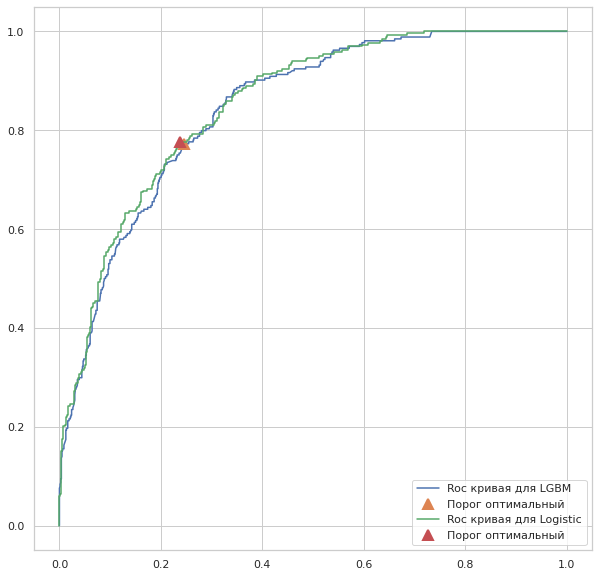

In [77]:
plt.figure(figsize=(10,10))

for m, val in clf_predict_proba.items():
    
    fpr, tpr, thresholds = roc_curve(y_valid, val)
    opt_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    tr_opt = thresholds[opt_idx]
    print(tr_opt)
    
    plt.plot(fpr, tpr, label='Roc кривая для '+m)
    close_default_rf = np.argmin(np.abs(thresholds - tr_opt))
    plt.plot(fpr[close_default_rf], tpr[close_default_rf], '^', markersize=10, label='Порог оптимальный', mew=2)
    plt.legend(loc=4)
    

In [78]:
clf_predict_proba

{'LGBM': array([0.5333315 , 0.03936147, 0.45261887, ..., 0.02905356, 0.46719279,
        0.13127275]),
 'Logistic': array([0.42338254, 0.05555304, 0.45950714, ..., 0.03884817, 0.45061733,
        0.04047822])}

## Анализ полученных результатов

In [79]:
preds = np.zeros(len(X_valid))
for key, prob in clf_predict_proba.items():

    preds += prob

# результат - это средний результат по всем классификаторам    
preds = preds/len(clf_predict_proba)
preds 

array([0.47835702, 0.04745725, 0.45606301, ..., 0.03395087, 0.45890506,
       0.08587548])

In [80]:
roc_auc_score(y_valid, preds)

0.849946501585846

In [81]:
y_pred = (preds>0.3).astype(int)
y_pred

array([1, 0, 1, ..., 0, 1, 0])

In [82]:
print('Confusion matrix:')
print(confusion_matrix(y_valid, y_pred))
print('Classification Report:')
print(classification_report(y_valid, y_pred))

Confusion matrix:
[[630 163]
 [ 70 194]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       793
           1       0.54      0.73      0.62       264

    accuracy                           0.78      1057
   macro avg       0.72      0.76      0.73      1057
weighted avg       0.81      0.78      0.79      1057



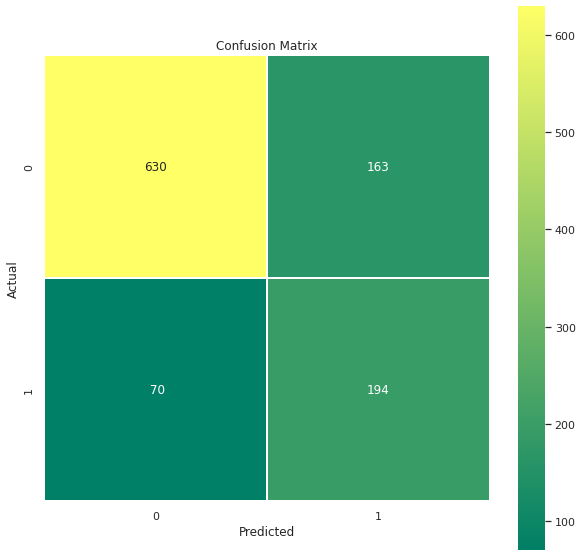

In [83]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_valid, y_pred), linewidths=0.1, square=True, annot=True, cmap='summer', fmt='3.0f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

## Прогноз

In [88]:
best_classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=RANDOM_STATE),
    "Logistic" : LogisticRegression(**clf_best_params["Logistic"], max_iter=3000, random_state=RANDOM_STATE)
   
}

In [89]:
y = y.astype(int)
preds = np.zeros(len(X_test))

for key, classifier in best_classifiers.items():
    start = time.time()
    
    cv = StratifiedKFold(n_splits=NUM_SPLIT_FOR_GRID, shuffle=True, random_state=RANDOM_STATE)

    score = 0

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
   
        X_train, X_valid = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_train, y_valid = y.iloc[train_idx], y.iloc[val_idx]
        
        clf = classifier
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_valid)[:,1]
        score_cur = roc_auc_score(y_valid, y_pred)
        
        score += score_cur        
        preds += clf.predict_proba(X_test)[:,1]

    
    score = score/NUM_SPLIT_FOR_GRID
    stop = time.time()
    
    print('Модель:', key)
    print('Средняя валидационная ошибка:', score)
    print('Время обучения:', round((stop - start)/60, 2))
    print()
    
    
# результат - это средний результат по всем разбиениям и всем классификаторам    
pred = preds/(NUM_SPLIT_FOR_GRID * len(best_classifiers))


Модель: LGBM
Средняя валидационная ошибка: 0.8441805242993154
Время обучения: 0.01

Модель: Logistic
Средняя валидационная ошибка: 0.8481782416046462
Время обучения: 0.27



In [90]:
pred

array([0.12085652, 0.67591817, 0.75690815, ..., 0.86353822, 0.71518015,
       0.0372835 ])

In [91]:
submission = {
    'Id': np.arange(len(pred)),
    'Churn': pred
}
solution = pd.DataFrame(submission)
solution.to_csv('data/submission.csv', index=False)

# Дополнительно

## LogisticRegressionCV

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                    y,
                                                    test_size=SPLIT_TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [85]:
clf = LogisticRegressionCV(cv=NUM_SPLIT_FOR_GRID, random_state=RANDOM_STATE, scoring='roc_auc',\
                           max_iter=3000, class_weight='balanced').fit(X_train, y_train)


In [96]:
y_pred = clf.predict_proba(X_valid)[:,1]
score_cur = clf.score(X_valid, y_valid)
score_cur

0.8514415911956895

## Pipeline

In [129]:
#https://towardsdatascience.com/ml-pipelines-with-grid-search-in-scikit-learn-2539d6b53cfb

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

categorical_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
# drop='first'
preprocessor = make_column_transformer(
    (numeric_transformer, num_cols),
    (categorical_transformer, cat_cols)
)

pipeline = make_pipeline(preprocessor, LogisticRegression(random_state=RANDOM_STATE, max_iter=3000, \
                                                          class_weight='balanced'))


In [105]:
X_train, X_valid, y_train, y_valid = train_test_split(X_catboost,
                                                    y,
                                                    test_size=SPLIT_TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [126]:
log_grid = {
    "logisticregression__C": [100, 10, 1, 0.1, 0.01, 0.001],
    
}

In [127]:
#clf = GridSearchCV(estimator=pipeline, param_grid=log_grid, n_jobs=-1, cv=5, scoring='roc_auc')
#clf.fit(X_train, y_train)

In [130]:
cv = StratifiedKFold(n_splits=NUM_SPLIT_FOR_GRID, shuffle=True, random_state=RANDOM_STATE)

clf = GridSearchCV(estimator=pipeline, param_grid=log_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_valid)[:,1]
clf.score(X_valid, y_valid)

0.8511502159043143

In [133]:
y_valid

5018    0
4729    0
4618    1
291     0
1784    0
       ..
4209    0
2004    0
1080    0
1118    0
5234    0
Name: Churn, Length: 1057, dtype: int64

## CatBoost

При использовании этого бустинга нам не нужно преобразовывать категориальные данные - они обрабатываются автоматически, а так как он основан на деревьях - не требуется так же масштабировать данные - деревья не относятся к метрическим методам

In [92]:
X_train, X_valid, y_train, y_valid = train_test_split(X_catboost,
                                                    y,
                                                    test_size=SPLIT_TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [93]:
X_train.head()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,HasPartner,HasChild,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,ClientPeriodInterval,MonthlySpendingInterval,HasNotInternet
2311,33,93.35,0,Yes,No,Yes,Fiber optic,No,Yes,Yes,No,Yes,Month-to-month,Yes,Electronic check,20-40,60-100,0
1664,15,83.05,1,Yes,No,Yes,Fiber optic,No,No,Yes,Yes,No,Month-to-month,Yes,Electronic check,2-20,60-100,0
4578,1,50.55,1,No,No,Yes,DSL,No,No,No,No,No,Month-to-month,No,Mailed check,0-2,30-60,0
595,66,104.25,0,No,No,Yes,Fiber optic,No,Yes,No,Yes,Yes,One year,Yes,Electronic check,60+,100+,0
869,2,74.95,0,No,No,No,Fiber optic,No,Yes,No,No,No,Month-to-month,No,Electronic check,0-2,60-100,0


In [94]:
n_estimators = [50, 70, 100]
learning_rate = [0.05, 0.1, 0.15]

In [95]:
#l = n_estimators * learning_rate
i = 0
res = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'roc-auc', 'time'])
for n_est in n_estimators:
    for l_rate in learning_rate:
        start = time.time()
        clf = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, n_estimators=n_est, learning_rate=l_rate)
        clf.fit(X_train, y_train, list(cat_cols))
        y_pred = clf.predict_proba(X_valid)[:,1]
        
        stop=time.time()
        
        res.loc[i] = [n_est, l_rate, roc_auc_score(y_valid, y_pred), round((stop-start)/60,2)]
        i += 1
        

In [167]:
res.sort_values(by='roc-auc', ascending=False)

,n_estimators,learning_rate,roc-auc,time
8,100.0,0.15,0.846873,0.01
5,70.0,0.15,0.845034,0.01
4,70.0,0.10,0.844938,0.01
6,100.0,0.05,0.844465,0.02
7,100.0,0.10,0.844461,0.01
2,50.0,0.15,0.844203,0.01
1,50.0,0.10,0.843078,0.01
3,70.0,0.05,0.840916,0.01
0,50.0,0.05,0.838478,0.01
